In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.api import OLS
import statsmodels.api as sm
from ISLP.models import ModelSpec as MS
from functools import partial
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

In [2]:
pbp = pd.read_csv("pbp-2023.csv")

In [3]:
pbp.shape

(51287, 45)

In [4]:
pbp.columns

Index(['GameId', 'GameDate', 'Quarter', 'Minute', 'Second', 'OffenseTeam',
       'DefenseTeam', 'Down', 'ToGo', 'YardLine', 'Unnamed: 10',
       'SeriesFirstDown', 'Unnamed: 12', 'NextScore', 'Description', 'TeamWin',
       'Unnamed: 16', 'Unnamed: 17', 'SeasonYear', 'Yards', 'Formation',
       'PlayType', 'IsRush', 'IsPass', 'IsIncomplete', 'IsTouchdown',
       'PassType', 'IsSack', 'IsChallenge', 'IsChallengeReversed',
       'Challenger', 'IsMeasurement', 'IsInterception', 'IsFumble',
       'IsPenalty', 'IsTwoPointConversion', 'IsTwoPointConversionSuccessful',
       'RushDirection', 'YardLineFixed', 'YardLineDirection',
       'IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay', 'PenaltyType',
       'PenaltyYards'],
      dtype='object')

In [5]:
pbp["Unnamed: 16"]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
51282   NaN
51283   NaN
51284   NaN
51285   NaN
51286   NaN
Name: Unnamed: 16, Length: 51287, dtype: float64

In [6]:
pbp.PlayType.value_counts()

PlayType
PASS                    19172
RUSH                    13219
KICK OFF                 2711
PUNT                     2268
TIMEOUT                  1965
SACK                     1495
EXTRA POINT              1173
SCRAMBLE                 1118
FIELD GOAL               1060
NO PLAY                   871
QB KNEEL                  429
TWO-POINT CONVERSION      139
FUMBLES                   102
CLOCK STOP                 68
EXCEPTION                  12
Name: count, dtype: int64

In [7]:
pbp.drop(["Unnamed: 10","Unnamed: 12","Unnamed: 16","Unnamed: 17","NextScore"], axis = 1, inplace = True)

In [8]:
pbp.isna().sum()

GameId                                0
GameDate                              0
Quarter                               0
Minute                                0
Second                                0
OffenseTeam                           0
DefenseTeam                           0
Down                                  0
ToGo                                  0
YardLine                              0
SeriesFirstDown                       0
Description                           0
TeamWin                               0
SeasonYear                            0
Yards                                 0
Formation                           830
PlayType                           5485
IsRush                                0
IsPass                                0
IsIncomplete                          0
IsTouchdown                           0
PassType                          32115
IsSack                                0
IsChallenge                           0
IsChallengeReversed                   0


In [9]:
pbp.columns

Index(['GameId', 'GameDate', 'Quarter', 'Minute', 'Second', 'OffenseTeam',
       'DefenseTeam', 'Down', 'ToGo', 'YardLine', 'SeriesFirstDown',
       'Description', 'TeamWin', 'SeasonYear', 'Yards', 'Formation',
       'PlayType', 'IsRush', 'IsPass', 'IsIncomplete', 'IsTouchdown',
       'PassType', 'IsSack', 'IsChallenge', 'IsChallengeReversed',
       'Challenger', 'IsMeasurement', 'IsInterception', 'IsFumble',
       'IsPenalty', 'IsTwoPointConversion', 'IsTwoPointConversionSuccessful',
       'RushDirection', 'YardLineFixed', 'YardLineDirection',
       'IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay', 'PenaltyType',
       'PenaltyYards'],
      dtype='object')

In [10]:
pbp.ToGo.mean()

6.596310955992747

In [11]:
pbp.IsMeasurement.value_counts()

IsMeasurement
0    51287
Name: count, dtype: int64

In [12]:
pbp.dtypes

GameId                              int64
GameDate                           object
Quarter                             int64
Minute                              int64
Second                              int64
OffenseTeam                        object
DefenseTeam                        object
Down                                int64
ToGo                                int64
YardLine                            int64
SeriesFirstDown                     int64
Description                        object
TeamWin                             int64
SeasonYear                          int64
Yards                               int64
Formation                          object
PlayType                           object
IsRush                              int64
IsPass                              int64
IsIncomplete                        int64
IsTouchdown                         int64
PassType                           object
IsSack                              int64
IsChallenge                       

In [13]:
pbp = pbp.sort_values(by = ['GameId','Quarter','Minute','Second'], ascending = [True,True,False,False])
# Since extra points and kickoffs are untimed, happen at the same time,sometimes kickoff is first and then extra point goes to wrong team
# sort so that PlayType == FIELD GOAL goes before KICK OFF in these cases

In [14]:
len(pbp.GameId.unique())

272

In [15]:
values = ['TIMEOUT','NO PLAY','CLOCK STOP','EXCEPTION']
pbp_less = pbp[~pbp['PlayType'].isin(values)]
pbp_less = pbp_less.dropna(subset=['PlayType'])

In [16]:
new_index = np.arange(len(pbp_less))

In [17]:
pbp_less.index = new_index
pbp_less.columns

Index(['GameId', 'GameDate', 'Quarter', 'Minute', 'Second', 'OffenseTeam',
       'DefenseTeam', 'Down', 'ToGo', 'YardLine', 'SeriesFirstDown',
       'Description', 'TeamWin', 'SeasonYear', 'Yards', 'Formation',
       'PlayType', 'IsRush', 'IsPass', 'IsIncomplete', 'IsTouchdown',
       'PassType', 'IsSack', 'IsChallenge', 'IsChallengeReversed',
       'Challenger', 'IsMeasurement', 'IsInterception', 'IsFumble',
       'IsPenalty', 'IsTwoPointConversion', 'IsTwoPointConversionSuccessful',
       'RushDirection', 'YardLineFixed', 'YardLineDirection',
       'IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay', 'PenaltyType',
       'PenaltyYards'],
      dtype='object')

In [18]:
pbp_less.PlayType.value_counts()

PlayType
PASS                    19172
RUSH                    13219
KICK OFF                 2711
PUNT                     2268
SACK                     1495
EXTRA POINT              1173
SCRAMBLE                 1118
FIELD GOAL               1060
QB KNEEL                  429
TWO-POINT CONVERSION      139
FUMBLES                   102
Name: count, dtype: int64

In [19]:
pbp_less['PlayType'] = pbp_less['PlayType'].replace({
    'SACK': 'PASS',
    'SCRAMBLE': 'PASS'
})

In [20]:
pbp_less['Team1'] = None
pbp_less['Team2'] = None
pbp_less['Team1Points'] = 0
pbp_less['Team2Points'] = 0
pbp_less['off_cum_num_run'] = 0
pbp_less['off_cum_num_pass'] = 0
pbp_less['off_cum_run_perc'] = 0
pbp_less['prev_big_run'] = 0
pbp_less['off_plus_minus'] = 0
pbp_less['off_perc_run_yards'] = 0
team1 = 'none'
team2 = 'none'

for x in pbp_less.GameId.unique():
    #print(f'Final Score: {team1} {team1_score} - {team2} {team2_score}')
    team1_score = 0
    team2_score = 0
    plays = pbp_less[pbp_less['GameId'] == x].copy()
    team1 = plays.OffenseTeam.iloc[0]
    team2 = plays.DefenseTeam.iloc[0]
    run_yards1 = 0
    run_yards2 = 0
    pass_yards1 = 0
    pass_yards2 = 0
    num_run1 = 0
    num_run2 = 0
    num_pas1 = 0
    num_pas2 = 0
    tot_runpass1 = 0
    tot_runpass2 = 0
    cum_run_perc1 = 0
    cum_run_perc2 = 0
    #print(team1, team2)
    big_run = 0
    row_current = plays.iloc[0]
    for index, row in plays.iterrows():
        
        if team1 == row_current.OffenseTeam:
            pbp_less.loc[row.name, 'off_cum_run_perc'] = cum_run_perc1
            pbp_less.loc[row.name, 'off_cum_num_pass'] = num_pas1
            pbp_less.loc[row.name, 'off_cum_num_run'] = num_run1
            pbp_less.loc[row.name, 'off_perc_run_yards'] = float(run_yards1 / (run_yards1 + pass_yards1)) if (run_yards1 + pass_yards1) > 0 else 0
        elif team2 == row_current.OffenseTeam:
            pbp_less.loc[row.name, 'off_cum_run_perc'] = cum_run_perc2
            pbp_less.loc[row.name, 'off_cum_num_pass'] = num_pas2
            pbp_less.loc[row.name, 'off_cum_num_run'] = num_run2
            pbp_less.loc[row.name, 'off_perc_run_yards'] = float(run_yards2 / (run_yards2 + pass_yards2)) if (run_yards2 + pass_yards2) > 0 else 0
        if row_current.OffenseTeam == team1:
            pbp_less.loc[row.name, 'off_plus_minus'] = team1_score - team2_score
        elif row_current.OffenseTeam == team2:
            pbp_less.loc[row.name, 'off_plus_minus'] = team2_score - team1_score
        pbp_less.loc[row.name, 'Team1Points'] = team1_score
        pbp_less.loc[row.name, 'Team2Points'] = team2_score

        row_current = row
        add_score1 = 0
        add_score2 = 0
        #print(index,row.OffenseTeam, row.DefenseTeam)
        if big_run == 1:
             pbp_less.at[row.name, 'prev_big_run'] = 1
        big_run = 0
        pbp_less.at[row.name, 'Team1'] = team1
        pbp_less.at[row.name, 'Team2'] = team2
        if 'TOUCHDOWN' in row.Description:
            if row.IsFumble == 1 and f'RECOVERED BY {row.DefenseTeam}' in row.Description:
                #print(f'TOUCHDOWN {row.DefenseTeam}')
                if row.DefenseTeam == team1:
                    add_score1 += 6
                elif row.DefenseTeam == team2:
                    add_score2 += 6
            elif 'INTERCEPTED' in row.Description or row.PlayType == 'PUNT':
                #print(f'TOUCHDOWN {row.DefenseTeam}')
                if row.DefenseTeam == team1:
                    add_score1 += 6
                elif row.DefenseTeam == team2:
                    add_score2 += 6
            elif 'FIELD GOAL IS BLOCKED' in row.Description:
                #print(f'TOUCHDOWN {row.DefenseTeam}')
                if row.DefenseTeam == team1:
                    add_score1 += 6
                elif row.DefenseTeam == team2:
                    add_score2 += 6
            else:
                #print(f'TOUCHDOWN{row.OffenseTeam}')
                if row.OffenseTeam == team1:
                    add_score1 += 6
                elif row.OffenseTeam == team2:
                    add_score2 += 6
        elif 'EXTRA POINT IS GOOD' in row.Description:
            #print(f'PAT{row.OffenseTeam}')
            if row.OffenseTeam == team1:
                add_score1 += 1
            elif row.OffenseTeam == team2:
                add_score2 += 1
        elif 'CONVERSION' in row.Description and 'ATTEMPT SUCCEEDS' in row.Description:
            #print(f'2 point success {row.OffenseTeam}')
            if row.OffenseTeam == team1:
                add_score1 += 2
            elif row.OffenseTeam == team2:
                add_score2 += 2
        elif 'FIELD GOAL IS GOOD' in row.Description:
            if row.OffenseTeam == team1:
                add_score1 += 3
            elif row.OffenseTeam == team2:
                add_score2 += 3

        if row.PlayType in ['PASS', 'SCRAMBLE', 'SACK']:
            if row.OffenseTeam == team1:
                num_pas1 += 1
            elif row.OffenseTeam == team2:
                num_pas2 += 1
        elif row.PlayType == 'RUSH':
            if row.OffenseTeam == team1:
                num_run1 += 1
            elif row.OffenseTeam == team2:
                num_run2 += 1
            
        if row.PlayType == 'RUSH' and row.Yards > 6:
            big_run = 1
        # Calculate total plays and percentages
        if row.IsRush == 1 and row.IsFumble == 0:
            if row.OffenseTeam == team1:
                run_yards1 += row.Yards
            elif row.OffenseTeam == team2:
                run_yards2 += row.Yards
        if row.IsPass == 1 and row.IsFumble == 0 and row.IsInterception == 0:
            if row.OffenseTeam == team1:
                pass_yards1 += row.Yards
            elif row.OffenseTeam == team2:
                pass_yards2 += row.Yards
                

        
        tot_runpass1 = float(num_pas1 + num_run1)
        tot_runpass2 = float(num_pas2 + num_run2)
        cum_run_perc1 = float(num_run1 / tot_runpass1) if tot_runpass1 > 0 else 0
        cum_run_perc2 = float(num_run2 / tot_runpass2) if tot_runpass2 > 0 else 0
        
        # Assign values to cumulative columns in pbp_less
        
        # Update cumulative scores

        
        team1_score += add_score1
        team2_score += add_score2
# add perc_yards that come from runs
# add cumulative run% & pass% as variables and num_runs & num_passes as well as if the play was a run of 10+ yards
# also fix untimed plays. Sometimes kickoffs are listed before PATS and possession goes to the other team before the PAT.
# should i try to lag the results? Example; if num_run_off goes up then it knows it was a run

/var/folders/z5/wycf3x413tdfj2x82rdw6yfh0000gn/T/ipykernel_85190/1171295248.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pbp_less.loc[row.name, 'off_cum_run_perc'] = cum_run_perc1
/var/folders/z5/wycf3x413tdfj2x82rdw6yfh0000gn/T/ipykernel_85190/1171295248.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.4444444444444444' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pbp_less.loc[row.name, 'off_perc_run_yards'] = float(run_yards2 / (run_yards2 + pass_yards2)) if (run_yards2 + pass_yards2) > 0 else 0


In [21]:
pbp_less.PlayType.value_counts()

PlayType
PASS                    21785
RUSH                    13219
KICK OFF                 2711
PUNT                     2268
EXTRA POINT              1173
FIELD GOAL               1060
QB KNEEL                  429
TWO-POINT CONVERSION      139
FUMBLES                   102
Name: count, dtype: int64

In [22]:
pbp_less_encode = pbp_less[(pbp_less['PlayType'] == 'RUSH') | (pbp_less['PlayType'] == 'PASS')]

In [23]:
pbp_less_encode.PlayType.value_counts()

PlayType
PASS    21785
RUSH    13219
Name: count, dtype: int64

In [24]:
copy = pbp_less_encode
pbp_less_encode['OffTeamName'] = pbp_less_encode['OffenseTeam']
pbp_less_encode['DefTeamName'] = pbp_less_encode['DefenseTeam']
X = pbp_less_encode.drop(["PlayType"], axis=1)
y = pbp_less_encode["PlayType"]
type(y)

/var/folders/z5/wycf3x413tdfj2x82rdw6yfh0000gn/T/ipykernel_85190/2052490234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_less_encode['OffTeamName'] = pbp_less_encode['OffenseTeam']
/var/folders/z5/wycf3x413tdfj2x82rdw6yfh0000gn/T/ipykernel_85190/2052490234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_less_encode['DefTeamName'] = pbp_less_encode['DefenseTeam']


pandas.core.series.Series

In [25]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder and fit it to your target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_encoded
pbp_less_encode['PlayType'] = y_encoded
pbp_less_encode['PlayType'].value_counts()
# pass = 0

/var/folders/z5/wycf3x413tdfj2x82rdw6yfh0000gn/T/ipykernel_85190/3851332535.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_less_encode['PlayType'] = y_encoded


PlayType
0    21785
1    13219
Name: count, dtype: int64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, shuffle=False)
encoder = ce.TargetEncoder(cols=['OffenseTeam', 'DefenseTeam','Formation'])
type(X_train),type(y_train), type(encoder)

(pandas.core.frame.DataFrame,
 numpy.ndarray,
 category_encoders.target_encoder.TargetEncoder)

In [27]:
encoder.fit(X_train,y_train)

X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [28]:
X_train['PlayType'] = y_train
X_test['PlayType'] = y_test

In [29]:
X_train

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,...,Team2Points,off_cum_num_run,off_cum_num_pass,off_cum_run_perc,prev_big_run,off_plus_minus,off_perc_run_yards,OffTeamName,DefTeamName,PlayType
1,2023090700,2023-09-07,1,15,0,0.408467,0.366255,1,10,25,...,0,0,0,0.000000,0,0,0.000000,DET,KC,1
2,2023090700,2023-09-07,1,14,29,0.408467,0.366255,2,3,32,...,0,1,0,1.000000,1,0,1.000000,DET,KC,0
3,2023090700,2023-09-07,1,14,25,0.408467,0.366255,3,3,32,...,0,1,1,0.500000,0,0,1.000000,DET,KC,0
5,2023090700,2023-09-07,1,14,9,0.314578,0.352078,1,10,13,...,0,1,2,0.333333,0,0,1.000000,KC,DET,1
6,2023090700,2023-09-07,1,13,34,0.314578,0.352078,2,5,18,...,0,1,0,1.000000,0,0,1.000000,KC,DET,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32164,2023121008,2023-12-10,3,9,24,0.347436,0.287671,2,8,15,...,10,13,21,0.382353,0,-4,0.300546,SEA,SF,0
32165,2023121008,2023-12-10,3,8,42,0.347436,0.287671,3,8,15,...,10,13,22,0.371429,0,-4,0.300546,SEA,SF,0
32166,2023121008,2023-12-10,3,8,4,0.347436,0.287671,1,10,31,...,10,13,23,0.361111,0,-4,0.276382,SEA,SF,1
32167,2023121008,2023-12-10,3,7,31,0.347436,0.287671,2,9,32,...,10,14,23,0.378378,0,-4,0.280000,SEA,SF,1


In [30]:
X_test

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,...,Team2Points,off_cum_num_run,off_cum_num_pass,off_cum_run_perc,prev_big_run,off_plus_minus,off_perc_run_yards,OffTeamName,DefTeamName,PlayType
32170,2023121008,2023-12-10,3,5,58,0.452632,0.364679,1,10,25,...,10,15,24,0.384615,0,-4,0.269036,SF,SEA,0
32171,2023121008,2023-12-10,3,5,8,0.452632,0.364679,1,10,70,...,10,9,21,0.300000,0,4,0.395954,SF,SEA,0
32172,2023121008,2023-12-10,3,5,4,0.452632,0.364679,2,10,70,...,10,9,22,0.290323,0,4,0.395954,SF,SEA,1
32173,2023121008,2023-12-10,3,4,23,0.452632,0.364679,1,10,82,...,10,10,22,0.312500,1,4,0.416201,SF,SEA,1
32174,2023121008,2023-12-10,3,3,42,0.452632,0.364679,2,9,83,...,10,11,22,0.333333,0,4,0.417827,SF,SEA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42879,2024010713,2024-01-07,4,1,53,0.404509,0.342175,1,10,37,...,20,30,46,0.394737,0,5,0.260521,MIA,BUF,0
42880,2024010713,2024-01-07,4,1,48,0.404509,0.342175,2,3,44,...,20,21,27,0.437500,0,-5,0.384354,MIA,BUF,0
42881,2024010713,2024-01-07,4,1,26,0.404509,0.342175,1,10,100,...,20,21,28,0.428571,0,-5,0.376667,MIA,BUF,0
42882,2024010713,2024-01-07,4,1,22,0.404509,0.342175,1,10,60,...,20,21,29,0.420000,0,-5,0.376667,MIA,BUF,0


In [31]:
pbp_less.prev_big_run.value_counts()

prev_big_run
0    40181
1     2705
Name: count, dtype: int64

In [32]:
X_combined = pd.concat([X_train, X_test])

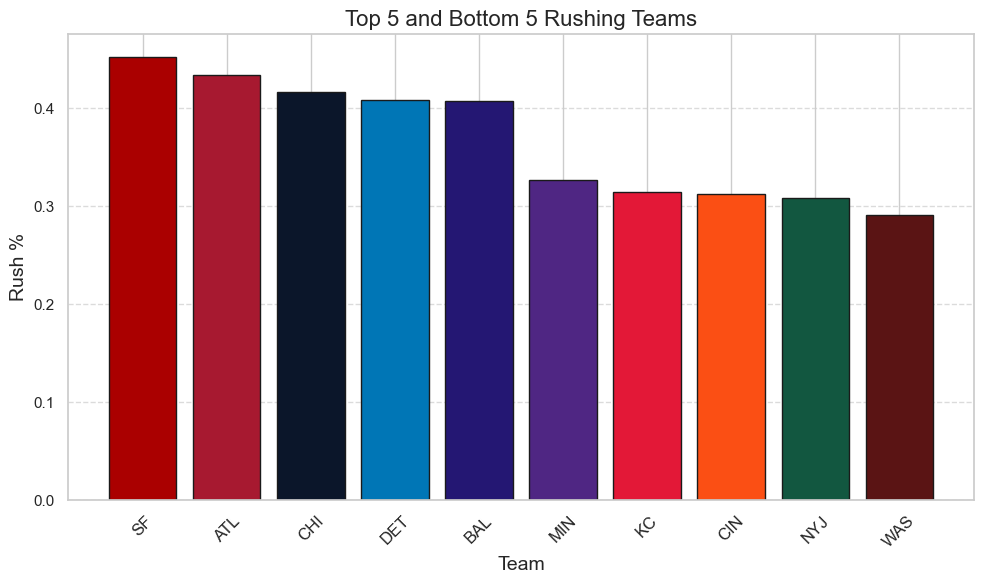

In [98]:
offteams = X_combined[['OffenseTeam','OffTeamName']]
unique_offteams = X_combined[['OffenseTeam', 'OffTeamName']].drop_duplicates(subset='OffTeamName')
unique_offteams = unique_offteams.sort_values(by = ['OffenseTeam'], ascending = [False])
top5_off = unique_offteams.head()
bottom5_off = unique_offteams.tail()
top_bottom5off = pd.concat([top5_off,bottom5_off])
colors = ['#AA0000','#a71930','#0B162A','#0076b6','#241773','#4F2683','#E31837','#fb4f14','#125740','#5A1414']
plt.figure(figsize=(10, 6))
plt.bar(top_bottom5off['OffTeamName'], top_bottom5off['OffenseTeam'], color=colors, edgecolor='k')
plt.title('Top 5 and Bottom 5 Rushing Teams', fontsize=16)
plt.ylabel('Rush %', fontsize=14)
plt.xlabel('Team', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("OFF_RUSH_PERCS_2023.png")
plt.show()

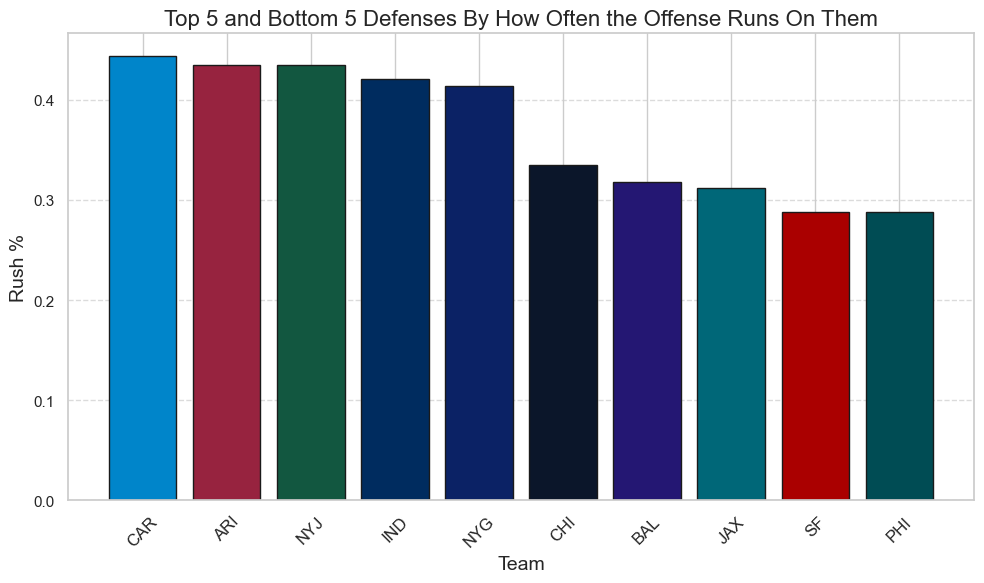

In [97]:
defteams = X_combined[['DefenseTeam','DefTeamName']]
unique_defteams = X_combined[['DefenseTeam', 'DefTeamName']].drop_duplicates(subset='DefTeamName')
unique_defteams = unique_defteams.sort_values(by = ['DefenseTeam'], ascending = [False])
top5_def = unique_defteams.head()
bottom5_def = unique_defteams.tail()
top_bottom5def = pd.concat([top5_def,bottom5_def])
colorsdef = ['#0085CA','#97233F','#125740','#002C5F','#0B2265','#0B162A','#241773','#006778','#AA0000','#004C54']
plt.figure(figsize=(10, 6))
plt.bar(top_bottom5def['DefTeamName'], top_bottom5def['DefenseTeam'], color=colorsdef, edgecolor='k')
plt.title('Top 5 and Bottom 5 Defenses By How Often the Offense Runs On Them', fontsize=16)
plt.ylabel('Rush %', fontsize=14)
plt.xlabel('Team', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("DEF_RUSH_PERCS_2023.png")
plt.show()

In [33]:
X_combined.columns

Index(['GameId', 'GameDate', 'Quarter', 'Minute', 'Second', 'OffenseTeam',
       'DefenseTeam', 'Down', 'ToGo', 'YardLine', 'SeriesFirstDown',
       'Description', 'TeamWin', 'SeasonYear', 'Yards', 'Formation', 'IsRush',
       'IsPass', 'IsIncomplete', 'IsTouchdown', 'PassType', 'IsSack',
       'IsChallenge', 'IsChallengeReversed', 'Challenger', 'IsMeasurement',
       'IsInterception', 'IsFumble', 'IsPenalty', 'IsTwoPointConversion',
       'IsTwoPointConversionSuccessful', 'RushDirection', 'YardLineFixed',
       'YardLineDirection', 'IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay',
       'PenaltyType', 'PenaltyYards', 'Team1', 'Team2', 'Team1Points',
       'Team2Points', 'off_cum_num_run', 'off_cum_num_pass',
       'off_cum_run_perc', 'prev_big_run', 'off_plus_minus',
       'off_perc_run_yards', 'OffTeamName', 'DefTeamName', 'PlayType'],
      dtype='object')

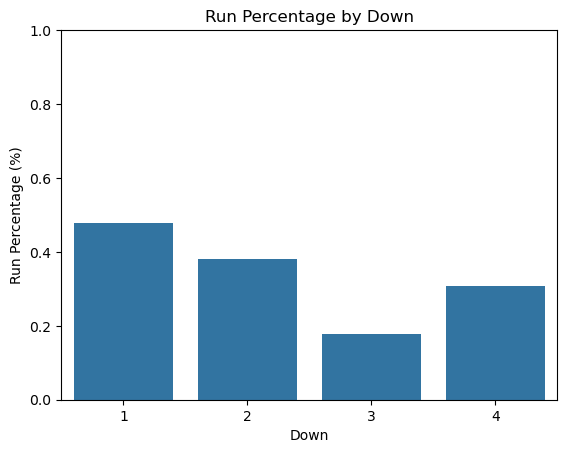

In [34]:
rush_frequency_by_down = copy.groupby('Down')['PlayType'].mean().reset_index()
sns.barplot(data=rush_frequency_by_down, x='Down', y='PlayType')
plt.title('Run Percentage by Down')
plt.xlabel('Down')
plt.ylabel('Run Percentage (%)')
plt.ylim(0, 1)  # Optional: Set y-axis from 0 to 1 for percentage representation
plt.show()

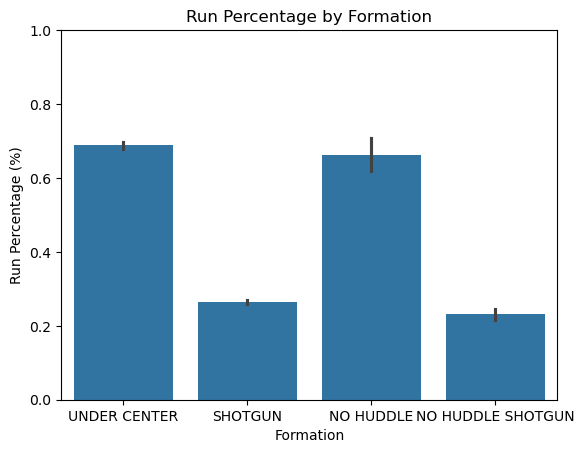

In [35]:
rush_frequency_by_down = copy.groupby('Formation')['PlayType'].mean().reset_index()
sns.barplot(data=copy, x='Formation', y='PlayType')
plt.title('Run Percentage by Formation')
plt.xlabel('Formation')
plt.ylabel('Run Percentage (%)')
plt.ylim(0, 1)  # Optional: Set y-axis from 0 to 1 for percentage representation
plt.show()

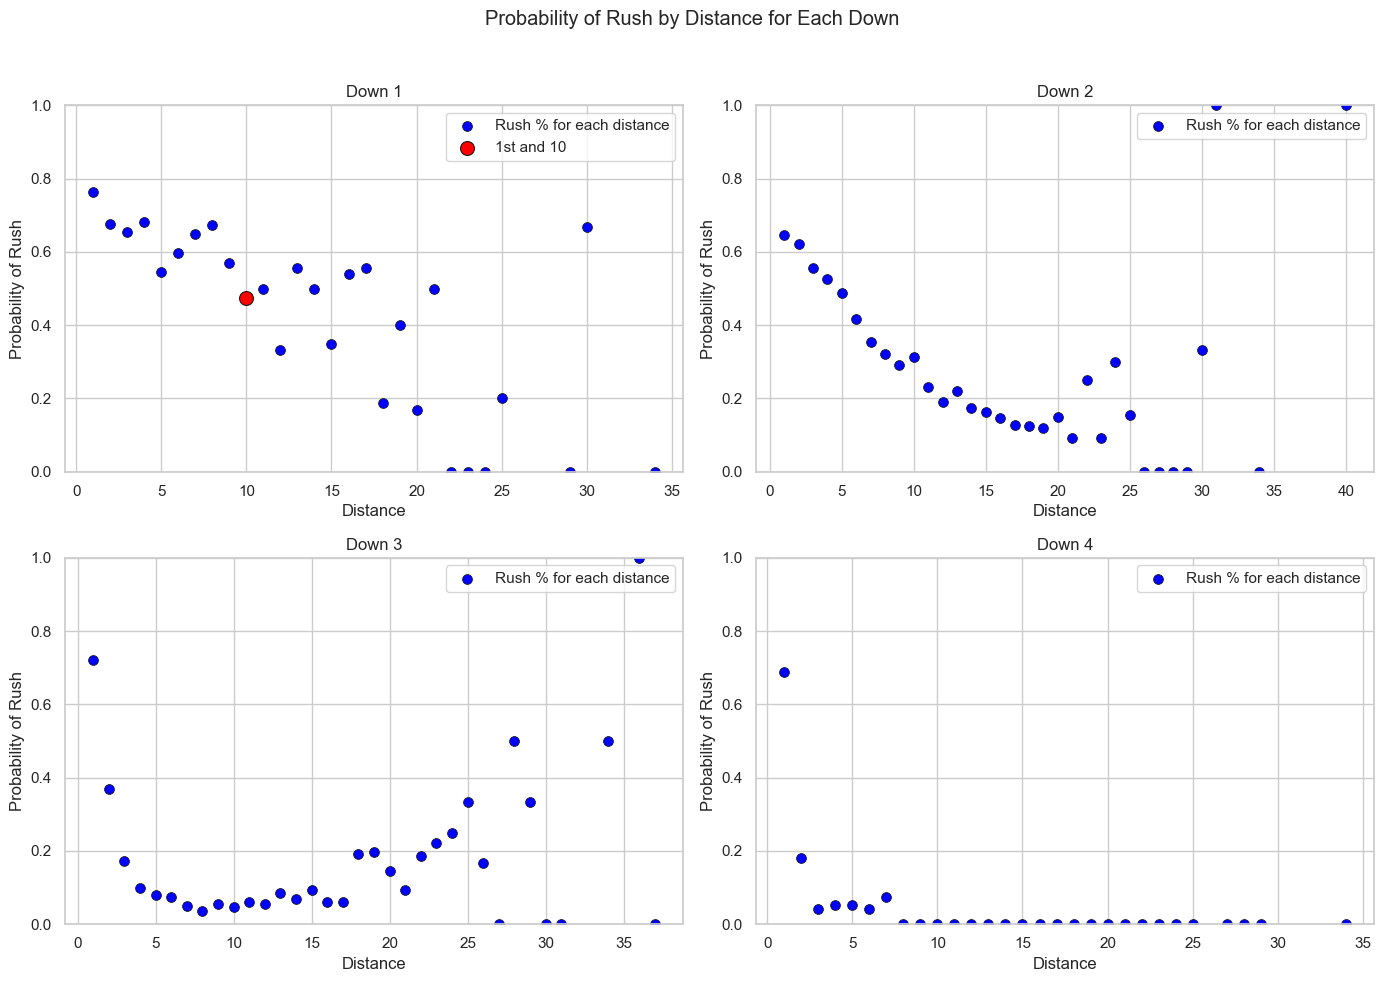

In [36]:
sns.set_theme(style="whitegrid")

highlight_distance = 5

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Probability of Rush by Distance for Each Down')

for i, down in enumerate([1, 2, 3, 4]):
    ax = axes[i // 2, i % 2]
    rush_prob_by_distance = copy[copy['Down'] == down].groupby('ToGo')['PlayType'].mean().reset_index()
    sns.scatterplot(data=rush_prob_by_distance, x='ToGo', y='PlayType', 
                    ax=ax, color='blue', edgecolor='k', s=50, label='Rush % for each distance')
    if down == 1:
        highlight_point = rush_prob_by_distance[rush_prob_by_distance['ToGo'] == 10]
    
        if not highlight_point.empty:
            sns.scatterplot(data=highlight_point, x='ToGo', y='PlayType', 
                        ax=ax, color='red', s=100, edgecolor='k', label=f'1st and 10')
    ax.set_title(f'Down {down}')
    ax.set_xlabel('Distance')
    ax.set_ylabel('Probability of Rush')
    ax.set_ylim(0, 1)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("Rush_Probs_By_Down_2023.png")
plt.show()


In [37]:
X_combined.prev_big_run.value_counts()

prev_big_run
0    32558
1     2446
Name: count, dtype: int64

# Try Boosting!!!!

In [38]:
encode_index = np.arange(len(pbp_less_encode))
pbp_less_encode.index = encode_index

In [39]:
X_combined.index = encode_index

In [40]:
X_combined

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,...,Team2Points,off_cum_num_run,off_cum_num_pass,off_cum_run_perc,prev_big_run,off_plus_minus,off_perc_run_yards,OffTeamName,DefTeamName,PlayType
0,2023090700,2023-09-07,1,15,0,0.408467,0.366255,1,10,25,...,0,0,0,0.000000,0,0,0.000000,DET,KC,1
1,2023090700,2023-09-07,1,14,29,0.408467,0.366255,2,3,32,...,0,1,0,1.000000,1,0,1.000000,DET,KC,0
2,2023090700,2023-09-07,1,14,25,0.408467,0.366255,3,3,32,...,0,1,1,0.500000,0,0,1.000000,DET,KC,0
3,2023090700,2023-09-07,1,14,9,0.314578,0.352078,1,10,13,...,0,1,2,0.333333,0,0,1.000000,KC,DET,1
4,2023090700,2023-09-07,1,13,34,0.314578,0.352078,2,5,18,...,0,1,0,1.000000,0,0,1.000000,KC,DET,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34999,2024010713,2024-01-07,4,1,53,0.404509,0.342175,1,10,37,...,20,30,46,0.394737,0,5,0.260521,MIA,BUF,0
35000,2024010713,2024-01-07,4,1,48,0.404509,0.342175,2,3,44,...,20,21,27,0.437500,0,-5,0.384354,MIA,BUF,0
35001,2024010713,2024-01-07,4,1,26,0.404509,0.342175,1,10,100,...,20,21,28,0.428571,0,-5,0.376667,MIA,BUF,0
35002,2024010713,2024-01-07,4,1,22,0.404509,0.342175,1,10,60,...,20,21,29,0.420000,0,-5,0.376667,MIA,BUF,0


In [41]:
X_combined.PlayType.value_counts()

PlayType
0    21785
1    13219
Name: count, dtype: int64

In [42]:
varspredict = X_combined[['Quarter','Minute','Second','OffenseTeam','DefenseTeam','Down','ToGo','YardLine','Formation','IsTwoPointConversion','off_cum_num_run','off_cum_num_pass','off_cum_run_perc','off_plus_minus','PlayType','prev_big_run','off_perc_run_yards']]

In [43]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

In [44]:
design1 = MS(varspredict.columns.drop('PlayType')).fit(varspredict)
Y = np.array(varspredict['PlayType'])
X = design1.transform(varspredict)

In [45]:
sigma2 = OLS(Y,X).fit().scale

In [46]:
neg_Cp = partial(nCp, sigma2)

In [47]:
strategy = Stepwise.first_peak(design1,
                               direction='forward',
                               max_terms=len(design1.terms))

In [48]:
runpass_mse = sklearn_selected(OLS,
                               strategy)
runpass_mse.fit(varspredict, Y)
runpass_mse.selected_state_

('DefenseTeam',
 'Down',
 'Formation',
 'Minute',
 'OffenseTeam',
 'Quarter',
 'Second',
 'ToGo',
 'YardLine',
 'off_cum_num_pass',
 'off_cum_num_run',
 'off_cum_run_perc',
 'off_perc_run_yards',
 'off_plus_minus',
 'prev_big_run')

In [49]:
runpass_Cp = sklearn_selected(OLS,
                               strategy,
                               scoring=neg_Cp)
runpass_Cp.fit(varspredict, Y)
runpass_Cp.selected_state_

('DefenseTeam',
 'Down',
 'Formation',
 'Minute',
 'OffenseTeam',
 'ToGo',
 'YardLine',
 'off_cum_num_pass',
 'off_cum_num_run',
 'off_cum_run_perc',
 'off_perc_run_yards',
 'off_plus_minus',
 'prev_big_run')

In [50]:
varspredict.dtypes

Quarter                   int64
Minute                    int64
Second                    int64
OffenseTeam             float64
DefenseTeam             float64
Down                      int64
ToGo                      int64
YardLine                  int64
Formation               float64
IsTwoPointConversion      int64
off_cum_num_run           int64
off_cum_num_pass          int64
off_cum_run_perc        float64
off_plus_minus            int64
PlayType                  int64
prev_big_run              int64
off_perc_run_yards      float64
dtype: object

In [51]:
X_combined.isna().sum()

GameId                                0
GameDate                              0
Quarter                               0
Minute                                0
Second                                0
OffenseTeam                           0
DefenseTeam                           0
Down                                  0
ToGo                                  0
YardLine                              0
SeriesFirstDown                       0
Description                           0
TeamWin                               0
SeasonYear                            0
Yards                                 0
Formation                             0
IsRush                                0
IsPass                                0
IsIncomplete                          0
IsTouchdown                           0
PassType                          15832
IsSack                                0
IsChallenge                           0
IsChallengeReversed                   0
Challenger                        35004


In [52]:
varspredict.columns

Index(['Quarter', 'Minute', 'Second', 'OffenseTeam', 'DefenseTeam', 'Down',
       'ToGo', 'YardLine', 'Formation', 'IsTwoPointConversion',
       'off_cum_num_run', 'off_cum_num_pass', 'off_cum_run_perc',
       'off_plus_minus', 'PlayType', 'prev_big_run', 'off_perc_run_yards'],
      dtype='object')

In [53]:
varspred = varspredict.columns.drop('PlayType')
varspredict.shape

(35004, 17)

In [54]:
allvars = varspredict[list(runpass_Cp.selected_state_)]
design = MS(allvars)
allvars

,DefenseTeam,Down,Formation,Minute,OffenseTeam,ToGo,YardLine,off_cum_num_pass,off_cum_num_run,off_cum_run_perc,off_perc_run_yards,off_plus_minus,prev_big_run
0,0.366255,1,0.685757,15,0.408467,10,25,0,0,0.000000,0.000000,0,0
1,0.366255,2,0.685757,14,0.408467,3,32,0,1,1.000000,1.000000,0,1
2,0.366255,3,0.260243,14,0.408467,3,32,1,1,0.500000,1.000000,0,0
3,0.352078,1,0.260243,14,0.314578,10,13,2,1,0.333333,1.000000,0,0
4,0.352078,2,0.260243,13,0.314578,5,18,0,1,1.000000,1.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34999,0.342175,1,0.260243,1,0.404509,10,37,46,30,0.394737,0.260521,5,0
35000,0.342175,2,0.260243,1,0.404509,3,44,27,21,0.437500,0.384354,-5,0
35001,0.342175,1,0.238574,1,0.404509,10,100,28,21,0.428571,0.376667,-5,0
35002,0.342175,1,0.260243,1,0.404509,10,60,29,21,0.420000,0.376667,-5,0


In [102]:
varspredict.PlayType.value_counts()[0]/(varspredict.PlayType.value_counts()[0] + varspredict.PlayType.value_counts()[1])

0.6223574448634441

In [55]:
X = design.fit_transform(allvars)
y = varspredict.PlayType == 1
type(y),type(X)

(pandas.core.series.Series, pandas.core.frame.DataFrame)

In [56]:
allvars

,DefenseTeam,Down,Formation,Minute,OffenseTeam,ToGo,YardLine,off_cum_num_pass,off_cum_num_run,off_cum_run_perc,off_perc_run_yards,off_plus_minus,prev_big_run
0,0.366255,1,0.685757,15,0.408467,10,25,0,0,0.000000,0.000000,0,0
1,0.366255,2,0.685757,14,0.408467,3,32,0,1,1.000000,1.000000,0,1
2,0.366255,3,0.260243,14,0.408467,3,32,1,1,0.500000,1.000000,0,0
3,0.352078,1,0.260243,14,0.314578,10,13,2,1,0.333333,1.000000,0,0
4,0.352078,2,0.260243,13,0.314578,5,18,0,1,1.000000,1.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34999,0.342175,1,0.260243,1,0.404509,10,37,46,30,0.394737,0.260521,5,0
35000,0.342175,2,0.260243,1,0.404509,3,44,27,21,0.437500,0.384354,-5,0
35001,0.342175,1,0.238574,1,0.404509,10,100,28,21,0.428571,0.376667,-5,0
35002,0.342175,1,0.260243,1,0.404509,10,60,29,21,0.420000,0.376667,-5,0


In [57]:
pbp_less_encode.Formation.value_counts()

Formation
SHOTGUN              22547
UNDER CENTER          9218
NO HUDDLE SHOTGUN     2837
NO HUDDLE              402
Name: count, dtype: int64

In [58]:
glm = sm.GLM(y,
             X,
             family = sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
intercept,-1.3501,0.200,-6.750,0.0
DefenseTeam,1.9366,0.333,5.813,0.0
Down,-0.7237,0.019,-37.125,0.0
Formation,3.5531,0.064,55.250,0.0
Minute,0.0211,0.003,7.411,0.0
OffenseTeam,2.9822,0.358,8.337,0.0
ToGo,-0.1348,0.004,-29.967,0.0
YardLine,0.0030,0.001,5.789,0.0
off_cum_num_pass,-0.0175,0.002,-8.739,0.0
off_cum_num_run,0.0347,0.003,11.027,0.0


In [59]:
len(results.predict())

35004

In [60]:
probs = results.predict()
labels = np.array([0] * len(results.predict()))
labels[probs > 0.5] = 1

In [61]:
confusion_table(labels, varspredict.PlayType)

Truth,0,1
Predicted,,
0,18728,6513
1,3057,6706


In [62]:
pbp_less_encode.PlayType.value_counts()

PlayType
0    21785
1    13219
Name: count, dtype: int64

In [63]:
np.mean(labels == varspredict.PlayType)

0.7266026739801166

In [64]:
X_combined.PlayType.value_counts()

PlayType
0    21785
1    13219
Name: count, dtype: int64

# NAIVE BAYES

In [65]:
X_trainnb, X_testnb, y_trainnb, y_testnb = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True, stratify = y)

In [66]:
NB = GaussianNB()
NB.fit(X_trainnb, y_trainnb)

GaussianNB()

In [67]:
nb_labels = NB.predict(X_testnb)
confusion_table(nb_labels, y_testnb)

Truth,False,True
Predicted,,
False,4519,1516
True,927,1789


In [68]:
np.mean(nb_labels == y_testnb)

0.7208319049251514

# KNN

In [69]:
knn1 = KNeighborsClassifier(n_neighbors=7)
X_trainknn, X_testknn = [np.asarray(X) for X in [X_trainnb, X_testnb]]
knn1.fit(X_trainknn, y_trainnb)
knn1_pred = knn1.predict(X_testknn)
confusion_table(knn1_pred, y_testnb)

Truth,False,True
Predicted,,
False,4191,2103
True,1255,1202


In [70]:
np.mean(knn1_pred == y_testnb)

0.6162724260084562

Curse of dimensionality. Too many predictors for KNN
Try again with less predictors!!!

# LOG REG

In [71]:
logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(X_trainknn, y_trainnb)
logit_pred = logit.predict_proba(X_testknn)
logit_labels = np.where(logit_pred[:,1] > .45, 1,0)
confusion_table(logit_labels, y_testnb)

Truth,False,True
Predicted,,
False,4547,1455
True,899,1850


In [72]:
np.mean(logit_labels == y_testnb)

0.7310021711804365

# QDA

In [73]:
X_trainnb

,intercept,DefenseTeam,Down,Formation,Minute,OffenseTeam,ToGo,YardLine,off_cum_num_pass,off_cum_num_run,off_cum_run_perc,off_perc_run_yards,off_plus_minus,prev_big_run
868,1.0,0.395939,3,0.260243,4,0.389714,7,44,29,12,0.292683,0.141631,0,0
27585,1.0,0.354726,2,0.238574,5,0.368000,1,43,37,15,0.288462,0.170807,-14,0
18026,1.0,0.318442,2,0.260243,4,0.395745,4,26,44,23,0.343284,0.412121,-7,0
10424,1.0,0.370987,3,0.260243,1,0.433984,24,60,21,9,0.300000,0.157233,-10,0
16380,1.0,0.435239,1,0.260243,1,0.395745,10,87,10,3,0.230769,0.153226,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16726,1.0,0.370070,1,0.260243,1,0.362757,10,64,34,28,0.451613,0.216374,3,0
24771,1.0,0.404203,2,0.260243,10,0.314578,9,26,11,10,0.476190,0.273333,11,0
29693,1.0,0.370070,1,0.671975,4,0.395745,10,83,32,13,0.288889,0.080692,9,0
16361,1.0,0.435239,1,0.260243,11,0.395745,10,11,3,3,0.500000,0.555556,0,0


In [74]:
X_trainqda = X_trainnb.drop(['intercept'],axis = 1)
X_testqda = X_testnb.drop(['intercept'],axis = 1)
X_testqda

,DefenseTeam,Down,Formation,Minute,OffenseTeam,ToGo,YardLine,off_cum_num_pass,off_cum_num_run,off_cum_run_perc,off_perc_run_yards,off_plus_minus,prev_big_run
60,0.366255,3,0.260243,0,0.408467,1,34,18,13,0.419355,0.299435,-7,0
253,0.393070,3,0.238574,0,0.350993,15,66,44,30,0.405405,0.483553,-14,0
27720,0.394265,2,0.260243,11,0.358442,9,58,4,2,0.333333,0.037037,0,0
29414,0.420935,1,0.238574,1,0.433984,10,39,18,8,0.307692,0.276042,3,0
24991,0.363636,1,0.260243,8,0.359179,10,39,44,20,0.312500,0.142857,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34359,0.355037,3,0.260243,14,0.314578,4,31,1,1,0.500000,1.000000,0,0
14505,0.361842,1,0.238574,9,0.386308,3,97,26,18,0.409091,0.333333,-14,1
16126,0.393070,3,0.260243,14,0.326316,12,5,9,4,0.307692,0.071429,0,0
34671,0.287500,1,0.260243,5,0.358442,3,97,17,11,0.392857,0.174129,10,0


In [75]:
qda = QDA(store_covariance = True)
qda.fit(X_trainqda, y_trainnb)
# try dropping intercept from X_trainnb

QuadraticDiscriminantAnalysis(store_covariance=True)

In [76]:
qda_pred = qda.predict(X_testqda)
confusion_table(qda_pred, y_testnb)

Truth,False,True
Predicted,,
False,4440,1406
True,1006,1899


In [77]:
np.mean(qda_pred == y_testnb)

0.7243743572163182

# Boosting

In [78]:
gb_clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=4255)
gb_clf.fit(X_trainqda, y_trainnb)
y_pred = gb_clf.predict(X_testqda)
accuracy = accuracy_score(y_testnb, y_pred)
print("Accuracy:", accuracy)



Accuracy: 0.7417438007084904


In [79]:
confusion_table(y_pred, y_testnb)

Truth,False,True
Predicted,,
False,4532,1346
True,914,1959


In [80]:
y_trainnb

868      False
27585     True
18026     True
10424    False
16380     True
         ...  
16726     True
24771    False
29693    False
16361     True
1774      True
Name: PlayType, Length: 26253, dtype: bool